In [2]:
from shapely.geometry import Point
from geopandas.tools import sjoin
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

In [3]:
df_columns = ['start_time', 'startstation_latitude', 'startstation_longitude', 'endstation_latitude', 'endstation_longitude', 'birthyear', 'gender', 'year']

In [4]:
df = pd.DataFrame(columns=df_columns)

path = "data/nyc/"
if not os.path.isfile(path + "citi-data.pkl"):
    for file in os.listdir(path):
        year = file[:4]
        if year.isnumeric() and int(year) < 2017:
            data = pd.read_csv(path + file)
            
            # add data year to df
            data.loc[:, 'year'] = int(year)
            
            # select only certain columns
            data_columns = data.columns.to_numpy()[[1, 5, 6, 9, 10, 13, 14, 15]].tolist()
            data = data.loc[:, data_columns]
            data.columns = df_columns
            df = pd.concat([df, data[df_columns]])
            
    df = df.reset_index(drop=True)
    
    # clean data and change dtypes

    df.year = df.year.astype('int64')

    # remove null and non-numeric values of birthyear
    df = df.loc[pd.to_numeric(df.birthyear, errors='coerce').notnull()]
    df.birthyear = df.birthyear.astype('int64')

    # remove all birthyears before 1920
    df = df.loc[df.birthyear > 1920]

    # remove invalid gender code
    df = df.loc[df.gender != 0]
    df.gender = df.gender.astype('int64')

    df = df.reset_index(drop=True)

    # assign precinct id to each bike trip according to startstation latitude and longitude
    precinct_data = load_precinct_data()

    # police precints are (lon, lat) so lon and lat are also reversed here
    geometry = [Point(xy) for xy in zip(df.loc[:, 'startstation_longitude'], df.loc[:, 'startstation_latitude'])]
    df = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=geometry)

    df = sjoin(df, precinct_data, how='left').drop(columns=['shape_area', 'shape_leng'])
    df = df.rename(columns={'index_right': 'precinct_id'})
    
    df.precinct_id = df.precinct_id.astype('int64')
    
    df = df.loc[df.precinct_id.notna()]
    df.precinct_id = df.precinct_id.astype('int64')
    
    df.to_pickle(path + "citi-data.pkl")

df = pd.read_pickle(path + "citi-data.pkl")

In [5]:
df.head()

,start_time,startstation_latitude,startstation_longitude,endstation_latitude,endstation_longitude,birthyear,gender,year,geometry,precinct_id
0,2014-01-01 00:00:06,40.711174,-73.996826,40.717290,-73.996375,1986,1,2014,POINT (-73.99683 40.71117),5
1,2014-01-01 00:00:38,40.741444,-73.975361,40.701221,-74.012342,1963,1,2014,POINT (-73.97536 40.74144),17
2,2014-01-01 00:03:59,40.754601,-73.971879,40.758491,-73.959206,1991,1,2014,POINT (-73.97188 40.75460),17
3,2014-01-01 00:05:15,40.751884,-73.977702,40.747659,-73.984907,1989,1,2014,POINT (-73.97770 40.75188),14
4,2014-01-01 00:05:18,40.683826,-73.976323,40.682166,-73.953990,1990,1,2014,POINT (-73.97632 40.68383),78


In [6]:
df.describe()

,startstation_latitude,startstation_longitude,endstation_latitude,endstation_longitude,birthyear,gender,year,precinct_id
count,2.455843e+07,2.455843e+07,2.455843e+07,2.455843e+07,2.455843e+07,2.455843e+07,2.455843e+07,2.455843e+07
mean,4.073622e+01,-7.398857e+01,4.073576e+01,-7.398852e+01,1.976909e+03,1.235978e+00,2.015087e+03,1.803932e+01
std,2.153332e-02,1.441042e-02,7.789568e-02,1.367851e-01,1.147031e+01,4.246088e-01,8.010296e-01,2.335866e+01
min,4.064654e+01,-7.402545e+01,0.000000e+00,-7.405950e+01,1.921000e+03,1.000000e+00,2.014000e+03,1.000000e+00
25%,4.072205e+01,-7.399851e+01,4.072182e+01,-7.399906e+01,1.969000e+03,1.000000e+00,2.014000e+03,6.000000e+00
50%,4.073726e+01,-7.398998e+01,4.073705e+01,-7.399003e+01,1.979000e+03,1.000000e+00,2.015000e+03,1.300000e+01
75%,4.075140e+01,-7.398042e+01,4.075097e+01,-7.398057e+01,1.986000e+03,1.000000e+00,2.016000e+03,1.700000e+01
max,4.080421e+01,-7.392850e+01,4.080421e+01,0.000000e+00,2.000000e+03,2.000000e+00,2.016000e+03,1.140000e+02


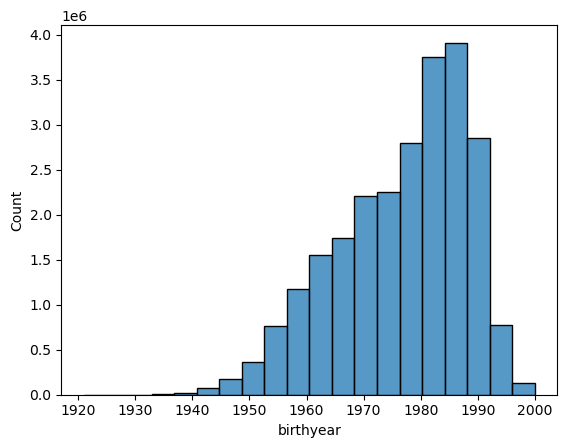

In [7]:
sns.histplot(df.birthyear, bins=20)
plt.show()

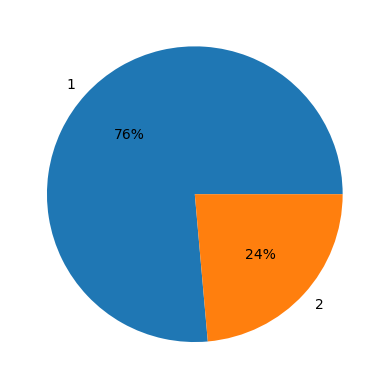

In [21]:
gender_ids, gender_counts = np.unique(df.gender, return_counts=True)

plt.pie(gender_counts.tolist(), labels=gender_ids.tolist(), autopct='%.0f%%')
plt.show()

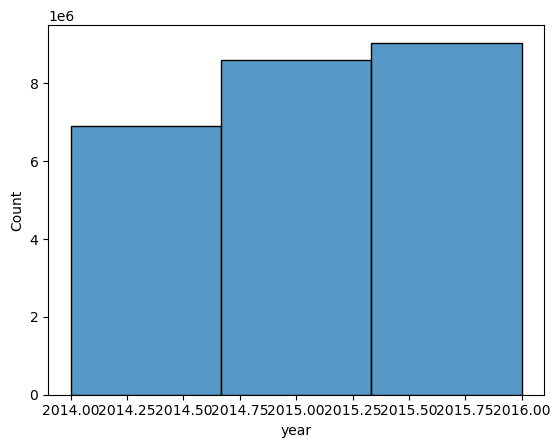

In [9]:
sns.histplot(df.year, bins=3)
plt.show()

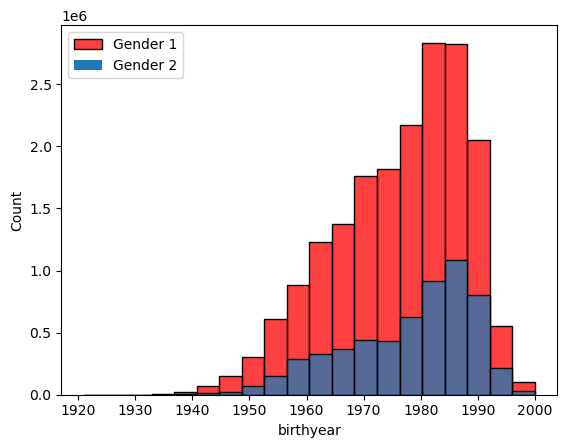

In [10]:
sns.histplot(df[df.gender == 1].birthyear, bins=20, color='r')
sns.histplot(df[df.gender == 2].birthyear, bins=20)
plt.legend(['Gender 1', 'Gender 2'])
plt.show()

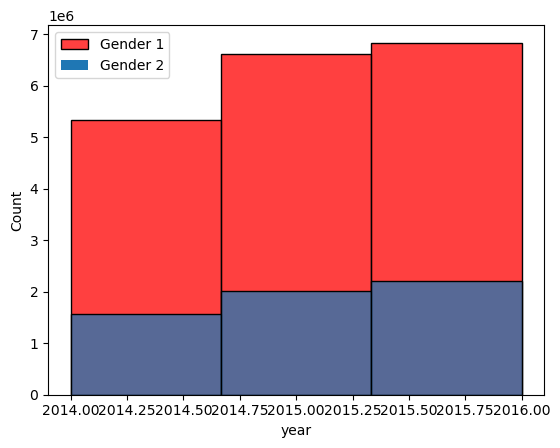

In [11]:
sns.histplot(df[df.gender == 1].year, bins=3, color='r')
sns.histplot(df[df.gender == 2].year, bins=3)
plt.legend(['Gender 1', 'Gender 2'])
plt.show()

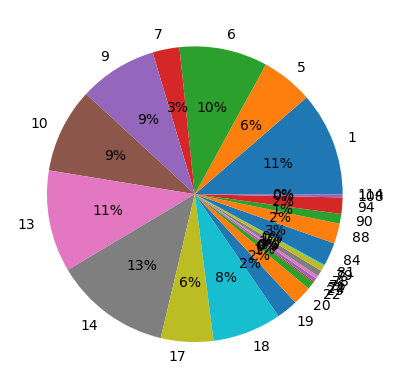

In [20]:
precinct_ids, precinct_counts = np.unique(df.precinct_id, return_counts=True)

plt.pie(precinct_counts.tolist(), labels=precinct_ids.tolist(), autopct='%.0f%%')
plt.show()